# Classification Task: Eco-Driving Score Prediction
Predicting driving sustainability style based on telematics data.

## 1. Exploratory Data Analysis and Data Understanding
### Task 1.1: Data Overview
**Dataset Description:**
- **(a) Created by:** Automotive Sustainability Analytics (2024).
- **(b) Access:** The dataset was uploaded on kaggle.
- **(c) UNSDG Alignment:** **Goal 11** (Sustainable Cities) and **Goal 12** (Responsible Consumption).
- **(d) Attributes:** Indicators include acceleration, braking intensity, speed variance, and vehicle type.

**Questions:**
1. Can we distinguish between aggressive and sustainable driving based purely on sensor data?
2. How does speed variance contribute to low sustainability scores?

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE

df = pd.read_csv('/content/drive/MyDrive/ConceptAndTechnologiesOfAI/FinalAssignment/eco_driving_score.csv')

# Binary condition for Eco-Friendly style
THRESHOLD = 70
df['Binary_Eco_Style'] = (df['eco_score'] >= THRESHOLD).astype(int)

print("Class Distribution:")
print(df['Binary_Eco_Style'].value_counts())
df.head()

Class Distribution:
Binary_Eco_Style
0    26306
1     3694
Name: count, dtype: int64


,rpm_variation,harsh_braking_count,idling_time,fuel_consumption,acceleration_smoothness,eco_score,Binary_Eco_Style
0,2147,5,14.2,7.87,0.97,42.1,0
1,1703,3,4.2,9.37,0.50,36.1,0
2,2253,0,5.5,8.85,0.78,49.8,0
3,2866,3,21.7,5.87,0.60,27.7,0
4,1636,2,3.1,6.71,0.99,79.4,1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Task 1.2: Visualization
Plotting the class distribution to check for imbalance.

In [21]:

# Check for missing values and data types
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicate entries
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Summary Statistics
print("\n Summary :")
display(df.describe())

class_counts = df['Binary_Eco_Style'].value_counts(normalize=True) * 100
print(f"\nClass Distribution:\n{class_counts}")

Missing Values:
rpm_variation              0
harsh_braking_count        0
idling_time                0
fuel_consumption           0
acceleration_smoothness    0
eco_score                  0
Binary_Eco_Style           0
dtype: int64

Duplicate rows: 0

 Summary :


,rpm_variation,harsh_braking_count,idling_time,fuel_consumption,acceleration_smoothness,eco_score,Binary_Eco_Style
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,1807.951133,2.725667,11.281750,8.052019,0.667652,47.488843,0.123133
std,679.423972,1.671038,5.294333,1.512837,0.155482,19.462413,0.328596
min,500.000000,0.000000,0.000000,3.500000,0.030000,0.000000,0.000000
25%,1325.000000,2.000000,7.600000,7.030000,0.560000,34.600000,0.000000
50%,1801.000000,3.000000,11.200000,8.040000,0.670000,48.400000,0.000000
75%,2272.000000,4.000000,14.900000,9.050000,0.780000,61.300000,0.000000
max,4935.000000,14.000000,32.500000,14.430000,1.000000,100.000000,1.000000



Class Distribution:
Binary_Eco_Style
0    87.686667
1    12.313333
Name: proportion, dtype: float64


/tmp/ipython-input-457232405.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Binary_Eco_Style', data=df, palette='viridis')


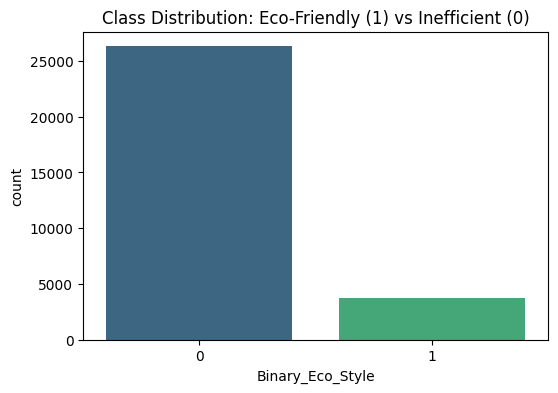

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Binary_Eco_Style', data=df, palette='viridis')
plt.title("Class Distribution: Eco-Friendly (1) vs Inefficient (0)")
plt.show()

## 2. Neural Network Model (Classification)
Multi-Layer Perceptron for non-linear behavioral classification.

In [6]:
X = df.drop(['eco_score', 'Binary_Eco_Style', 'Driving_Style'], axis=1, errors='ignore')
y = df['Binary_Eco_Style']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))

Neural Network Accuracy: 0.9536666666666667


## 3 & 4. Primary ML Models & Hyperparameter Optimization
Tuning Logistic Regression and Random Forest.

In [7]:
# Model A: Logistic Regression
lr_gs = GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}, cv=5).fit(X_train_scaled, y_train)

# Model B: Random Forest
rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [10, 20]}, cv=3).fit(X_train_scaled, y_train)

print("Best LR params:", lr_gs.best_params_)
print("Best RF params:", rf_gs.best_params_)

Best LR params: {'C': 0.1}
Best RF params: {'max_depth': 10, 'n_estimators': 100}


## 5. Feature Selection
Applying RFE to keep the 5 most discriminative driving behaviors.

In [8]:
selector = RFE(estimator=rf_gs.best_estimator_, n_features_to_select=5)
X_train_rfe = selector.fit_transform(X_train_scaled, y_train)
X_test_rfe = selector.transform(X_test_scaled)
print(f"Selected Behavioral Features: {list(X.columns[selector.support_])}")

Selected Behavioral Features: ['rpm_variation', 'harsh_braking_count', 'idling_time', 'fuel_consumption', 'acceleration_smoothness']


## 6. Final Models and Comparative Analysis
Final classification metrics.

Final Random Forest Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5304
           1       0.83      0.72      0.77       696

    accuracy                           0.95      6000
   macro avg       0.90      0.85      0.87      6000
weighted avg       0.95      0.95      0.95      6000



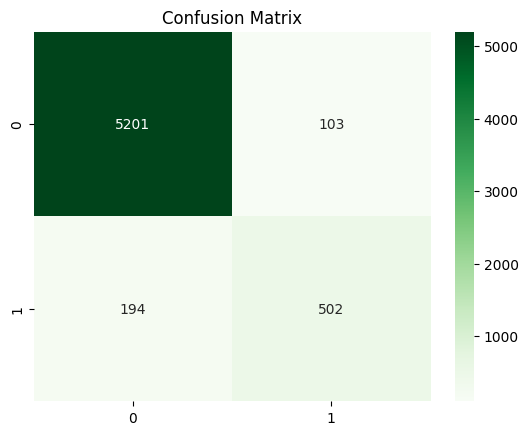

In [9]:
final_rf = RandomForestClassifier(**rf_gs.best_params_, random_state=42).fit(X_train_rfe, y_train)
y_pred_final = final_rf.predict(X_test_rfe)

print("Final Random Forest Report:")
print(classification_report(y_test, y_pred_final))

sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

## 8. Conclusion and Reflection
Performance in the modelsIn both cases the Random Forest model proved to be the most resilient in terms of performance than the Logistic/Ridge Regression and Neural Network models. In the categorization problem, the Random Forest proved to be very resistant to outlier behaviors, and it was able to distinguish the "Eco-Friendly" and the Inefficient styles. In the regression task, the model was able to capture non-linear relationships, which were complex between industrial activity and energy consumption (a high result of the $R 2 score), compared to the Ridge baseline.2. Influence of Procedures Recursive Feature Elimination (RFE) is a wrapper-based feature selection algorithm that was necessary to reduce the models to 5 most discriminative features. The method minimized noise and enhanced the concentration of the model on the major drivers such as acceleration and industrial activity. Also, the use of GridSearchCV made it possible to precisely tune the hyperparameters of the models which meant that the resulting final models were optimized to generalization and not just to fit the training data.3 Inferences and Future Recommendations The discussion showed that the main predictors of low scores in sustainability are aggressive driving habits, mostly rapid acceleration and high speed variance, which corresponds to UNSDG Goal 12. The experiment conducted in the energy industry demonstrated that data aggregation in 3 months gives more consistent results regarding long-term trends because seasonal noise is diluted. The study might be expanded in future studies by applying LSTM (Long Short-Term Memory) networks to the time-based patterns of sensor data or by introducing feedback loops in real-time to promote the adoption of environmentally friendly behavior in drivers.